In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib import patches
import ipywidgets as widgets
sns.set_style('whitegrid')
sns.set_color_codes()
sns.set_context('poster')
%matplotlib notebook

In [2]:
data = pd.read_csv('./hw_2_data/flowers.csv')

In [3]:
def plot_features(feature_list, color_by):
    axes = []
    if color_by.dtype not in (int, float):
        categories = color_by.unique()
        palette = sns.color_palette(palette='husl', n_colors=len(categories))
        colormap = {cat: palette[i] for i, cat in enumerate(categories)}
        colors = [colormap[color] for color in color_by]
        handles = [patches.Patch(color=colormap[cat]) for cat in categories]
        labels = categories
    else:
        colormap = ScalarMappable(cmap='viridis')
        colormap.set_array(color_by)
        colors = colormap.to_rgba(color_by)
    n_features = len(feature_list)
    fig = plt.figure(figsize=(3*n_features, 3*n_features))
    for i in range(n_features):
        for j in range(i+1):
            ax = plt.subplot(n_features, n_features, n_features*i+j+1)
            ax.set_xlim(min(feature_list[j]), max(feature_list[j]))
            ax.set_ylim(min(feature_list[i]), max(feature_list[i]))
            ax.scatter(feature_list[j], feature_list[i], color=colors, linewidth=0)
            if j != 0:
                plt.setp(ax.get_yticklabels(), visible=False)
            else:
                ax.set_ylabel(feature_list[i].name)
            if i != n_features-1:
                plt.setp(ax.get_xticklabels(), visible=False)
            else:
                ax.set_xlabel(feature_list[j].name)
            axes.append(ax)
    if color_by.dtype not in (int, float):
        fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.9, 0.9), title=color_by.name)
    else:
        fig.colorbar(colormap, ax=axes, label=color_by.name)
    return fig

In [64]:
class DrawRectangle(object):
    
    def __init__(self, fig):
        self.fig = fig
        self.coord_start = None
        self.coord_end = None
        self.start_axis = None
        self.end_axis = None
        self.rect = None
        self.cids = []
        
    def connect(self):
        self.cids.append(self.fig.canvas.mpl_connect('button_press_event', self.on_click))
        self.cids.append(self.fig.canvas.mpl_connect('button_release_event', self.on_release))
        
    def on_click(self, event):
        if self.rect is not None:
            self.rect.remove()
        self.coord_start = (event.xdata, event.ydata)
        self.start_axis = event.inaxes
        
    def on_release(self, event):
        self.coord_end = (event.xdata, event.ydata)
        self.end_axis = event.inaxes
        w.value = '%s %s %s %s'%(self.get_rect())
        if (self.start_axis == self.end_axis):
        x1, y1, width, height = self.get_rect()
        self.rect = self.end_axis.add_patch(patches.Rectangle((x1, y1), width, height, alpha=0.2))
        self.fig.canvas.draw()
        
    def get_rect(self):
        x1, x2 = sorted([self.coord_start[0], self.coord_end[0]])
        y1, y2 = sorted([self.coord_start[1], self.coord_end[1]])
        width = x2-x1
        height = y2-y1
        return x1, y1, width, height
    
    def disconnect(self):
        [self.fig.canvas.mpl_disconnect(cid) for cid in cids]

<IPython.core.display.Javascript object>


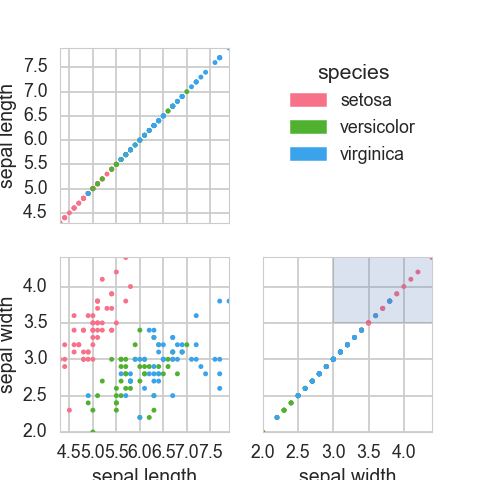

In [65]:
feature_list = [data['sepal length'],
                data['sepal width']
]
w = widgets.HTML()
fig = plot_features(feature_list, color_by=data['species'])
r = DrawRectangle(fig)
r.connect()
w